In [89]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [90]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\benign',224))
malign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\malignant',224))
benign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\benign',224))
malign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\malignant',224))

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 148.97it/s]


In [91]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

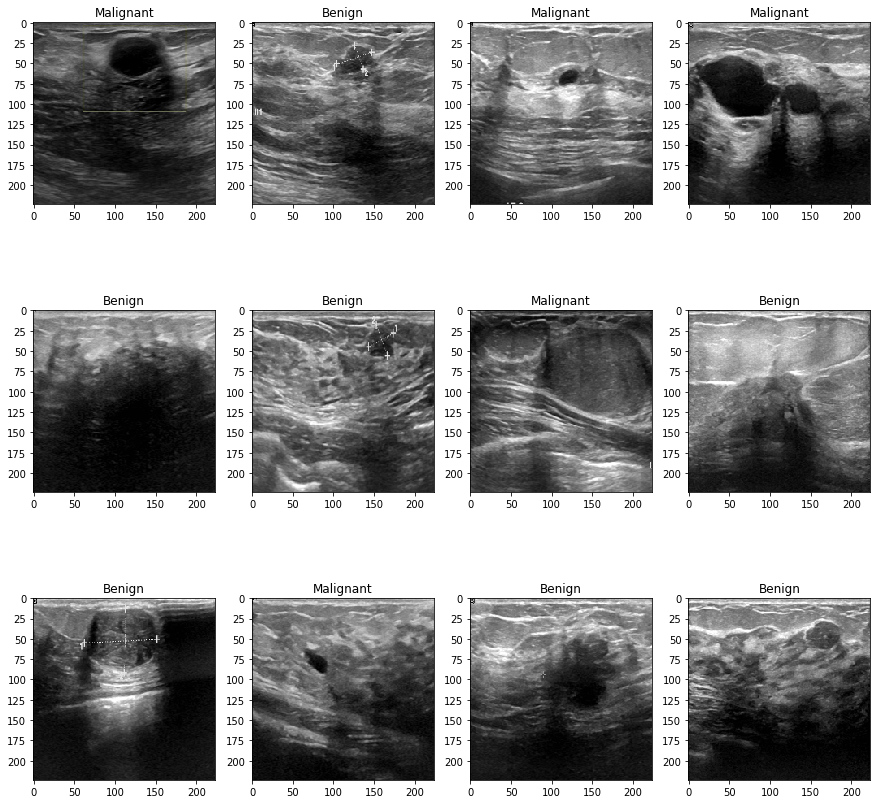

In [92]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [93]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [94]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [95]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [96]:
for layer in vgg.layers:
  layer.trainable = False

In [97]:
from glob import glob
folders = glob('C:/Users/pauls/Desktop/Dataset_tumor/Train/*')
print(len(folders))

2


In [98]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

y = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(y)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [99]:
from tensorflow.keras.optimizers import Adam


adam = Adam()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [100]:
model_history = model.fit(x_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(x_val,y_val))

Epoch 1/10
46/46 [==============================] - 73s 2s/step - loss: 2.4004 - accuracy: 0.6641 - val_loss: 1.2271 - val_accuracy: 0.8246
Epoch 2/10
46/46 [==============================] - 73s 2s/step - loss: 0.6754 - accuracy: 0.9397 - val_loss: 1.3598 - val_accuracy: 0.8246
Epoch 3/10
46/46 [==============================] - 75s 2s/step - loss: 0.1771 - accuracy: 0.9817 - val_loss: 1.3931 - val_accuracy: 0.7982
Epoch 4/10
46/46 [==============================] - 79s 2s/step - loss: 0.0626 - accuracy: 0.9981 - val_loss: 1.7614 - val_accuracy: 0.7895
Epoch 5/10
46/46 [==============================] - 77s 2s/step - loss: 0.0498 - accuracy: 0.9984 - val_loss: 1.5696 - val_accuracy: 0.8246
Epoch 6/10
46/46 [==============================] - 77s 2s/step - loss: 0.4179 - accuracy: 0.9899 - val_loss: 1.7482 - val_accuracy: 0.8070
Epoch 7/10
46/46 [==============================] - 78s 2s/step - loss: 0.0784 - accuracy: 0.9900 - val_loss: 1.7626 - val_accuracy: 0.7895
Epoch 8/10
46/46 [==

In [101]:
Y_pred = model.predict(X_test, steps=1,verbose =2)

1/1 - 11s


Confusion matrix, without normalization
[[52  2]
 [ 2 22]]


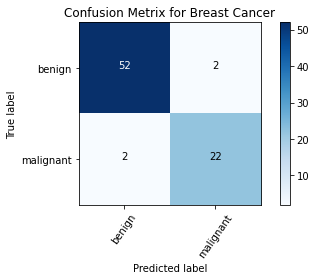

In [102]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

<AxesSubplot:>

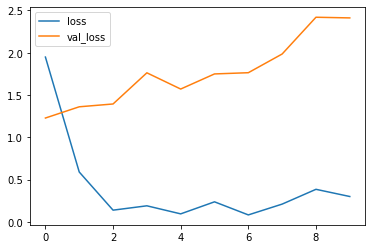

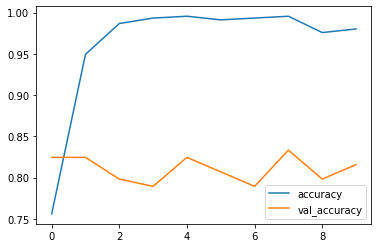

In [104]:
history_df = pd.DataFrame(model_history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(model_history.history)
history_df[['accuracy', 'val_accuracy']].plot()